20241229 Cumulative cases before isolation: 3 (95% CI: 2 - 7) Cumulative cases after isolation: 3 (95% CI: 2 - 6)
20250103 Cumulative cases before isolation: 5 (95% CI: 2 - 11) Cumulative cases after isolation: 4 (95% CI: 2 - 9)
20250108 Cumulative cases before isolation: 7 (95% CI: 3 - 18) Cumulative cases after isolation: 6 (95% CI: 2 - 13)
20250113 Cumulative cases before isolation: 10 (95% CI: 4 - 28) Cumulative cases after isolation: 8 (95% CI: 3 - 19)


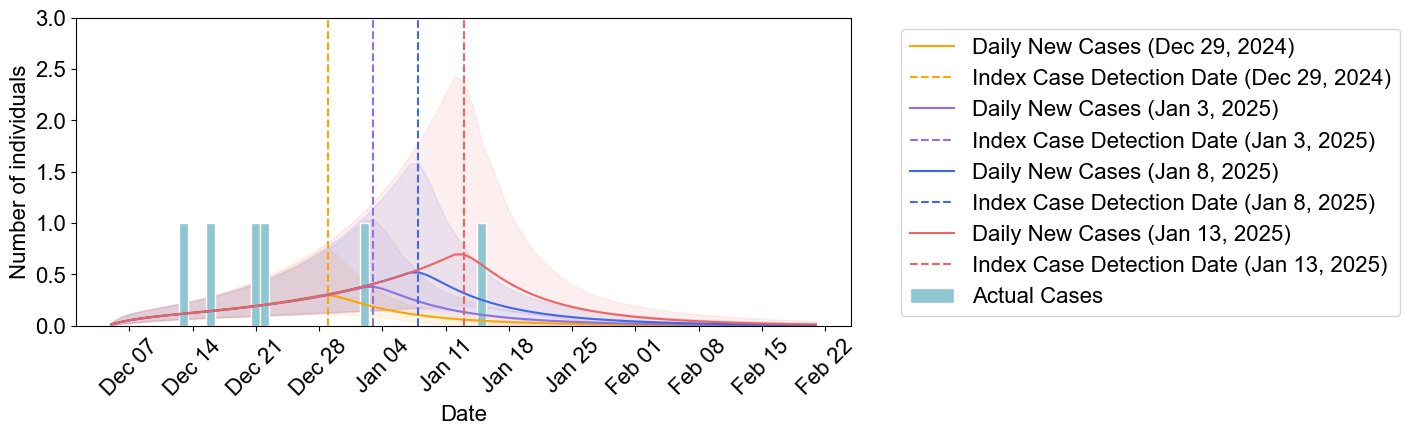

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

# Set the global font to Arial with a size of 16 points
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

# Model parameter settings
N = 1400000000  # Simulated population
I0 = 1  # Initial number of infected individuals
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # Initial number of isolated individuals
R0_range = (1.78, 2.69)
time_steps = 80  # Simulation time steps (days)
# Remove the definition of the fixed recovery rate
# recovery_rate = 1 / 9.4  
isolation_rate = 0  # Assumed isolation rate, can be adjusted according to actual situation
enhanced_isolation_rate = 0.5  # Enhanced isolation rate after detecting cases

# Parameters for the incubation period and infectious period
latency_mean = 7
latency_std = (12 - 2) / 4  # Assume a normal distribution where 95% of the data falls between 2 - 12 days
infectious_mean = 14
# Calculate the standard deviation based on the 95% confidence interval
infectious_std = (15 - 13) / 4

# Time points
t = np.linspace(0, time_steps, time_steps)

# Different days of case discovery
discovery_days = [24, 29, 34, 39]
# Convert RGB values to decimals between 0 and 1
new_colors = [(255/255, 165/255, 0/255), (147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255), (238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025', 'Jan 13, 2025']

# Define the differential equations of the SEIRQ model
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # The number of recovered individuals includes those who were not isolated and those who recovered after isolation
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # The number of individuals entering isolation minus the number of individuals recovering after isolation
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# Visualize the results
plt.figure(figsize=(10, 4))

# Fix the skewness parameter a = 1
a = 0
# Define the start date
start_date = np.datetime64('2024-12-05')
# Generate the corresponding date sequence
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])


for i, start_isolation_day in enumerate(discovery_days):
    # Monte Carlo simulation
    num_simulations = 1000  # Number of simulations
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # Randomly select an R0 value
        r0 = np.random.uniform(*R0_range)
        # Generate a right - skewed infectious period
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(4, min(27, infectious_period))  # Limit it to 4 - 27 days
        # Calculate the recovery rate gamma
        gamma = 1 / infectious_period
        # Calculate the transmission coefficient beta
        beta = r0 * gamma
        # Randomly generate the latent rate omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # Limit it to 2 - 12 days
        omega = 1 / latency

        # Initial conditions
        y0 = [S0, E0, I0, R0, 0, Q0]

        # Solve the differential equations
        solution = odeint(seirq_model, y0, t, args=(beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # Take the difference of X to get the daily new cases
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # Calculate the cumulative cases
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # Calculate the average cumulative cases
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # Find the index corresponding to the isolation date
    isolation_index = int(start_isolation_day)

    # Calculate the cumulative cases before and after isolation
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # Calculate the 95% confidence intervals of the cumulative cases before and after isolation
    before_isolation_cumulative = all_cumulative_cases[:, isolation_index - 1]
    after_isolation_cumulative = all_cumulative_cases[:, -1] - before_isolation_cumulative

    before_lower = np.percentile(before_isolation_cumulative, 2.5)
    before_upper = np.percentile(before_isolation_cumulative, 97.5)
    after_lower = np.percentile(after_isolation_cumulative, 2.5)
    after_upper = np.percentile(after_isolation_cumulative, 97.5)

    # Convert the date to the specified format
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y%m%d')

    # Output the results, including the 95% confidence intervals
    print(f"{formatted_date} Cumulative cases before isolation: {cumulative_before_isolation:.0f} (95% CI: {before_lower:.0f} - {before_upper:.0f}) Cumulative cases after isolation: {cumulative_after_isolation:.0f} (95% CI: {after_lower:.0f} - {after_upper:.0f})")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # Calculate the average of the daily new cases
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # Calculate the 95% confidence interval
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # Since the length of the data is reduced by 1 after taking the difference, the corresponding date sequence also needs to be reduced by 1
    date_sequence_daily = date_sequence[:-1]

    # Plot the average of the daily new cases (solid line)
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # Plot the 95% confidence interval
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # Add a vertical line for the start of the isolation date, with the same color as the corresponding date
    isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date ({labels[i]})')

    # Prepare the data to be saved to Excel
    data = {
        'Number of simulations': np.arange(1, num_simulations + 1),
        'Cumulative cases before isolation': before_isolation_cumulative,
        'Cumulative cases after isolation': after_isolation_cumulative
    }
    df = pd.DataFrame(data)

    # Save the data to the corresponding worksheet in Excel
    df.to_excel(writer, sheet_name=labels[i], index=False)

# New bar chart data
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# Convert the dates to numpy date format
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# Define the bar color and edge color
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# Plot the bar chart
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
# plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# Handle the legend duplication problem
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Place the legend on the right side of the picture
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the background grid lines
plt.grid(False)

# Set the y - axis range
plt.ylim(0, 3)

# Set the date format
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Display a date every 7 days

# Tilt the x - axis dates by 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

# Save the Excel file
#writer.close()